# FargoCPT Bootstrap Notebook

## What is this?
This notebook can be used to setup a FargoCPT simulation in an empty directory.

## Why is this useful?
This is useful when you want to run a simulation on a cluster which you can access using Jupyter notebooks and want to store a full copy of the code alongside your simulation outputs.

## Contents

It will do the following things:
- clone the repository from github
- compile the code
- give you a command to run the simulation
- print the available data
- plot the surface density

First we create a new directory and change to it.

In [1]:
example_name = "300_bootstrap"
!mkdir -p $example_name
import os
os.chdir(example_name)

## Downloading the code

We will clone only the last commit of the code which is enough to run the simulation and faster to download.

In [2]:
!git clone --depth 1 https://github.com/rometsch/fargocpt code

Cloning into 'code'...


remote: Enumerating objects: 742, done.
remote: Counting objects: 100% (742/742), done.
remote: Compressing objects: 100% (624/624), done.
remote: Total 742 (delta 156), reused 456 (delta 86), pack-reused 0
Receiving objects: 100% (742/742), 5.00 MiB | 22.05 MiB/s, done.
Resolving deltas: 100% (156/156), done.


## Building the code

Make sure the code is built by running make again.

In [3]:
%%timeit -n1 -r1
from sys import platform
if platform in ["linux", "darwin"]:
    !make -j 4 -C code/src > make.log
else:
    raise RuntimeError(f"Seems like you are not running MacOS or Linux but {platform}. This is unsupported. You are on your own, good luck!")

25.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Preparing a setup file

We'll take the example setup file from the examples directory and modify it in python.
If you want to create setup files for a parameter study, just copy the code and make your own setup creator script.

In [4]:
configfile = "setup.yml"
!cp ../config.yml $configfile

We'll use the `ruamel.yaml` package to read and write the setup file. This can be set up to preserve comments which is very useful if you want to trace your decisions later on.

In [5]:
try:
    import ruamel.yaml
except ImportError:
    raise ImportError("Please install ruamel.yaml with `python3 -m pip install ruamel.yaml`")
yaml = ruamel.yaml.YAML()
with open(configfile, "r") as infile:
    config = yaml.load(infile)

In [6]:
config["nbody"][1]["accretion efficiency"] = "2"
config["MonitorTimestep"] = 0.314 # monitor scalar files around every half orbit
config["Nmonitor"] = 20 # write a snapshot every orbit
config["Nsnapshots"] = 30 # wirte 10 snapshots
# use very low resolution by setting it to 2 cell per scaleheight, cps
del config["Nrad"]
del config["Naz"]
config["cps"] = 2

In [7]:
with open(configfile, "w") as outfile:
    yaml.dump(config, outfile)

## Running the code

We can start fargo using the python interface, but this runs slower when started from within a Jupyter Notebook compared to being executed from without.
Even calling a python script using the shell magic "!" does not speed it up.
Calling a python script that does the same job from the command line does not have this issue.

If anyone knows why this is, please let me know!

For a production run, even for further testing, please open a terminal and run the output of the following cell:

In [9]:
cwd = os.getcwd()
cmd = f"cd {cwd} && code/run_fargo -np 1 -nt 4 auto {configfile}"
print(cmd)

cd /home/rometsch/repo/fargocpt/examples/300_bootstrap && code/run_fargo -np 1 -nt 4 auto setup.yml


If you plan to run on a cluster, put something similar into a run script to be queued in the queueing system.

Consider generating your queuing script here so you can just copy this notebook and setup a new simulation.

For the sake of this notebook, we just run the simluation here.

In [10]:
import sys
sys.path.append("code/bin")
from fargocpt import run_fargo
run_fargo(2, 1, ["start", configfile], detach=False)

Running command: mpirun -np 2 --report-pid /tmp/tmp_cdhyc5r -x OMP_NUM_THREADS=1 /home/rometsch/repo/fargocpt/examples/300_bootstrap/code/bin/fargocpt start setup.yml
fargo process pid 1303015

[0] MPI rank #  0 runs as process 1303019
[1] MPI rank #  1 runs as process 1303020
[0] MPI rank #  0 OpenMP thread #  0 of  1 on cpt-kamino
[1] MPI rank #  1 OpenMP thread #  0 of  1 on cpt-kamino
[0] fargo: This file was compiled on Nov 13 2023, 20:16:57.
[0] fargo: This version of FARGO used _GNU_SOURCE
[0] fargo: This version of FARGO used NDEBUG. So no assertion checks!
[0] Using parameter file setup.yml
[0] Computing disk quantities within 5.00000e+00 L0 from coordinate center
[0] BC: Inner composite = reflecting
[0] BC: Outer composite = reflecting
[0] BC: Sigma inner = zerogradient
[0] BC: Sigma outer = zerogradient
[0] BC: Energy inner = zerogradient
[0] BC: Energy outer = zerogradient
[0] BC: Vrad inner = reflecting
[0] BC: Vrad outer = reflecting
[0] BC: Vaz inner = keplerian
[0] BC: 

0

## Some plots

In [11]:
try:
    from disgrid import Data
except ImportError:
    raise ImportError("Please install disgrid with `python3 -m pip install git+https://github.com/rometsch/disgrid")
d = Data("output/out")
d.avail()

{'fluids': {'gas': {'2d': ['Sigma', 'vrad', 'vtheta', 'energy'],
   'scalar': ['time step',
    'analysis time step',
    'physical time',
    'mass',
    'radius',
    'angular momentum',
    'total energy',
    'internal energy',
    'kinematic energy',
    'potential energy',
    'radial kinetic energy',
    'azimuthal kinetic energy',
    'eccentricity',
    'periastron',
    'viscous dissipation',
    'luminosity',
    'pdivv',
    'inner boundary mass inflow',
    'inner boundary mass outflow',
    'outer boundary mass inflow',
    'outer boundary mass outflow',
    'wave damping inner mass creation',
    'wave damping inner mass removal',
    'wave damping outer mass creation',
    'wave damping outer mass removal',
    'density floor mass creation',
    'aspect ratio',
    'indirect term nbody x',
    'indirect term nbody y',
    'indirect term disk x',
    'indirect term disk y',
    'frame angle',
    'advection torque',
    'viscous torque',
    'gravitational torque',
    '

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mplcolors

def plot_field(data, name, N, ax=None, dataunit=None, vmin=None, vmax=None, cmap="viridis"):
    field = data.get(var=name, dim="2d", N=N)
    if dataunit is None:
        dataunit = field.data.unit
    Z = field.data.to_value(dataunit)

    ri = field.grid.get_interfaces("r").to_value("au")
    phii = field.grid.get_interfaces("phi").to_value("rad")
    PHI, R = np.meshgrid(phii, ri)
    X = R*np.cos(PHI)
    Y = R*np.sin(PHI)

    if ax is None:
        fig, ax = plt.subplots(dpi=150)
    else:
        fig = ax.get_figure()

    norm = mplcolors.Normalize(vmin=vmin, vmax=vmax)
    pcm = ax.pcolormesh(X,Y,Z, norm=norm, cmap=cmap)
    ax.set_aspect("equal")

    t = field.time.to_value("kyr")
    ax.set_title(f" t={t:.2e}kyr, N={N}")

    cbar = fig.colorbar(pcm, ax=ax)
    cbar.set_label(f"{name} [{dataunit}]")
    
    return fig

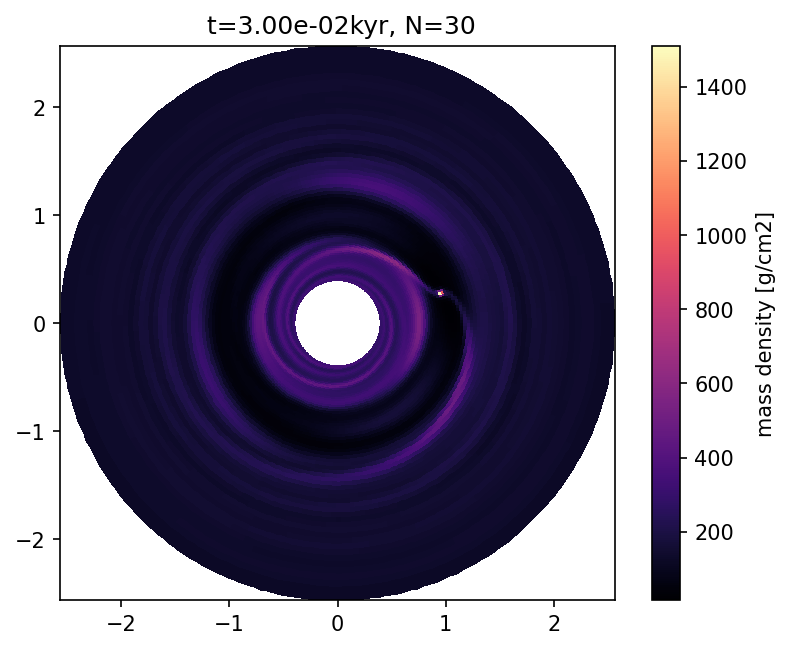

In [13]:
Nlast = d.avail()["Nlast"]
plot_field(d, "mass density", Nlast, dataunit="g/cm2", cmap="magma");

Text(0, 0.5, '$\\Sigma$ [g/cm2]')

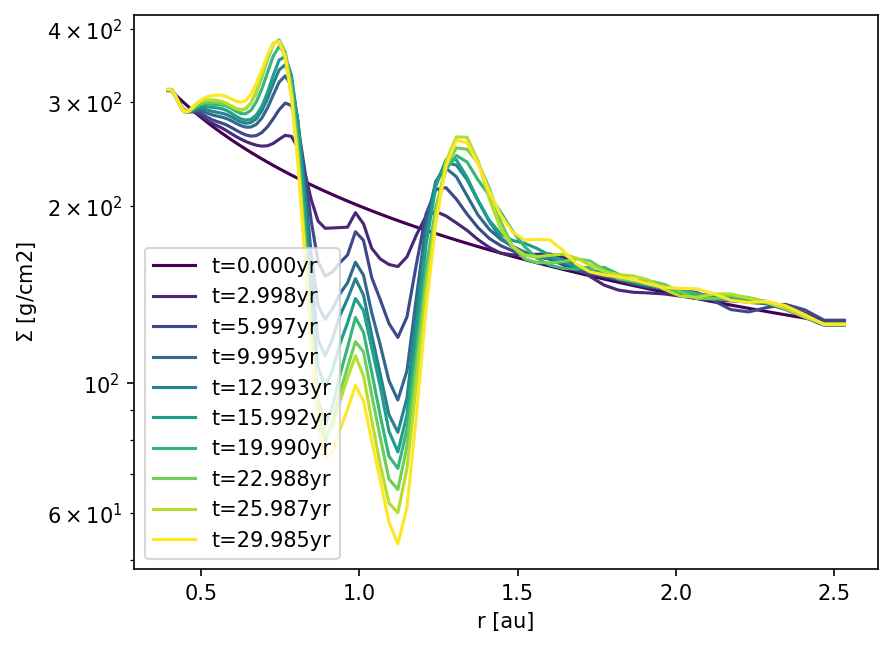

In [14]:
from matplotlib import colormaps

name = "mass density"
dataunit = "g/cm2"

Nfirst = d.avail()["Nfirst"]
Nlast = d.avail()["Nlast"]

fig, ax = plt.subplots(dpi=150)

field = d.get(dim="2d", var="mass density", N=0)
profile0 = np.average(field.data.to_value(dataunit), axis=1)

cmap = colormaps.get_cmap("viridis")

inds = np.linspace(Nfirst, Nlast, 10, dtype=int)
for k, n in enumerate(inds):
    color = cmap(k/(len(inds)-1))
    
    field = d.get(dim="2d", var="mass density", N=n)
    r = field.grid.get_centers("r").to_value("au")
    Z = field.data.to_value(dataunit)
    
    y = np.average(Z, axis=1)
    
    t = field.time.to_value("yr")
    # ax.plot(r, (profile-profile0)/profile0, label=f"t={t:.3f}yr")
    line, = ax.plot(r, y, label=f"t={t:.3f}yr", color=color)
    
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("r [au]")
ax.set_ylabel(fr"$\Sigma$ [{dataunit}]")